<a href="https://colab.research.google.com/github/kunai-3txk/Prediction-of-seriously-ill-patients/blob/main/BaseLine_featureselect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [2]:
!pip install catboost
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 31.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os

import warnings
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import polars as pl

import xgboost as xgb
import seaborn as sns; sns.set()


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb #LightGBM
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,Pool

# ーーーー 以下が、Neural Network に関連 ーーーー
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import os
from tensorflow.keras import regularizers
# ーーーーーーーーーーーーーーーーーーーーーーーーーー

#config

In [4]:
class config:
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 5
    N_BAGGING = 3
    UNDER_SAMPLING = True
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/ill"
    
    SUBMISSION = common_path + "/submission.csv"
    TRAIN = common_path + "/train_df.csv"
    TEST = common_path + "/test_df.csv"
    SUB_OUT = common_path + "/sub/"
     

#def

## def seed_everything

In [5]:
def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

## def stats

In [23]:
# 各変数のユニーク数、数、型、欠損値の有無等を確認
# 下記の関数は、https://www.kaggle.com/code/itkin16/catboost-on-gpu-baseline　　から引用
# オリジナル作成者を尊重し、コメントアウトしてある箇所も、そのまま引用してあります。

def stats(data):
    
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
        # 'nunique/len': data.nunique()/len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
        # 'Nullpercent' : data.isna().sum()/len(data),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len','types','Nulls'#,'Nullpercent', 'nunique/len'
                   ,"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)

#Load Data

In [6]:
train = pd.read_csv(paths.TRAIN)
print('train shape:',train.shape)

test = pd.read_csv(paths.TEST)
print('test shape:',test.shape)

submission = pd.read_csv(paths.SUBMISSION)
print('submission shape:',submission.shape)

train shape: (51359, 85)
test shape: (12840, 84)
submission shape: (12840, 2)


#EDA

In [ ]:
# 世代のtarget_encoding
t = train[['age','target_label']]
t['age_r'] = t['age'].round(-1)
t.groupby('age_r').mean()

train[['x5','target_label']].describe()

t = train[['age','respiratory_rate']]
t['age_r'] = t['age'].round(-1)
t.groupby('age_r').mean()


In [70]:

stats_train = pd.concat([stats(train.iloc[:, 0:50]) ,stats(train.iloc[:, 50:100])],axis=0)
stats_test = pd.concat([stats(test.iloc[:, 0:50]) ,stats(test.iloc[:, 50:100])],axis=0)

# te の候補探し
stats_train[(stats_train['nunique'] <= 100) & (stats_train['nunique'] >= 10)]



train[['glasgow_coma_scale_1','glasgow_coma_scale_2','glasgow_coma_scale_3','glasgow_coma_scale_4']].describe()

train_eda = train.copy()
test_eda = test.copy()
# https://ja.wikipedia.org/wiki/Glasgow_Coma_Scale
train_eda['glasgow_coma_scale_sum'] = train['glasgow_coma_scale_1']+train['glasgow_coma_scale_2']+train['glasgow_coma_scale_3']+train['glasgow_coma_scale_4']

df_temp = train_eda[['glasgow_coma_scale_sum','target_label']]
#df_temp = train_eda[['glasgow_coma_scale_3','target_label']]
df_temp_t0 = df_temp[df_temp['target_label']==0]
df_temp_t0 = df_temp_t0.dropna()
df_temp_t1 = df_temp[df_temp['target_label']==1]
df_temp_t1 = df_temp_t1.dropna()

#t検定
from scipy import stats
t, p = stats.ttest_ind(df_temp_t0['glasgow_coma_scale_sum'], df_temp_t1['glasgow_coma_scale_sum'],equal_var=False)
print('p:', p)
if p < 0.05:
  print('p < 0.05')

train_eda[train_eda['glasgow_coma_scale_3']==1]

,nunique,len,types,Nulls,Value counts Max,Value counts Min
v4,91,51359,float64,116,1487,40
v6,91,51359,float64,801,1459,40
v7,79,51359,float64,220,3463,8
blood_pressure_2,78,51359,float64,87,1957,50
blood_pressure_4,78,51359,float64,583,1940,50
age,74,51359,float64,2372,1250,22
respiratory_rate,66,51359,float64,709,2386,1
v8,52,51359,float64,220,6132,1
icu_5,44,51359,float64,938,6604,20
v9,36,51359,float64,187,33715,1


In [93]:
df_tmp = train_eda[['x5','target_label']]
df_tmp.groupby('x5').mean().sort_values('target_label')

df_tmp = train_eda[['x6','target_label']]
df_tmp.groupby('x6').mean().sort_values('target_label')



,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,...,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,51359,12058,66446,83.0,37.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Sepsis,NaN
1,51360,92348,32311,185.0,60.0,32.961764,1.0,0.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51361,68371,20639,157.0,70.0,19.295957,NaN,1.0,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Respiratory,Respiratory
3,51362,19544,116026,60.0,54.0,27.900747,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51363,85588,102404,196.0,85.0,39.414062,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Cardiovascular,Cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,64194,79880,56511,19.0,39.0,23.147277,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastrointestinal,Gastrointestinal
12836,64195,97405,32055,136.0,79.0,27.759515,0.0,NaN,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cardiovascular,Cardiovascular
12837,64196,31970,117733,70.0,56.0,28.331661,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neurological,Neurologic
12838,64197,76051,93359,189.0,79.0,24.578812,NaN,1.0,African American,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Gastrointestinal,Gastrointestinal


# Data Clean

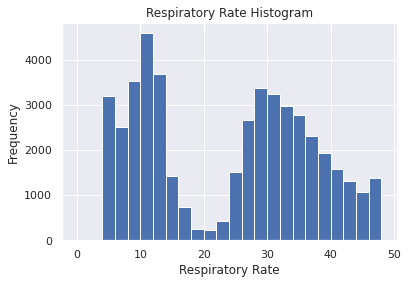

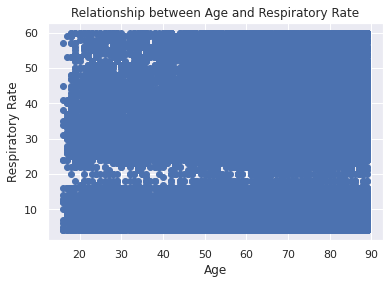

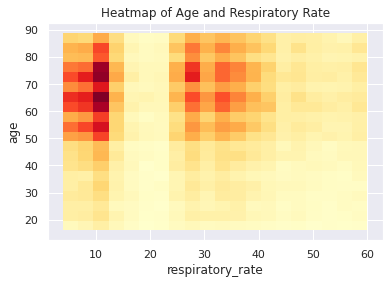

In [8]:
#train.info()]

train[['age','respiratory_rate']]

plt.hist(train['respiratory_rate'], bins=range(0, 50, 2))
plt.title('Respiratory Rate Histogram')
plt.xlabel('Respiratory Rate')
plt.ylabel('Frequency')
plt.show()


plt.scatter(train['age'], train['respiratory_rate'])
plt.title('Relationship between Age and Respiratory Rate')
plt.xlabel('Age')
plt.ylabel('Respiratory Rate')
plt.show()


sns.histplot(x='respiratory_rate', y='age', data=train, bins=20, cmap='YlOrRd')
plt.title('Heatmap of Age and Respiratory Rate')
plt.show()

In [9]:
target_col = ['target_label']

num_cols = ['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6'
            ,'glasgow_coma_scale_1', 'glasgow_coma_scale_2','glasgow_coma_scale_3', 'glasgow_coma_scale_4'
            , 'heart_rate', 'blood_oxy', 'arterial_pressure',
            'respiratory_rate', 'temp'
            , 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4',
            'v1_heartrate_max'
            , 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14','v15', 'v16'
            , 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14','w15', 'w16', 'w17', 'w18'
            , 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# id, personal_id_1, personal_id_2 以外のカテゴリー変数
whole_cat_cols = [c for c in test.columns if c not in num_cols and c not in ['id', 'personal_id_1', 'personal_id_2']]

#for c in whole_cat_cols:
#  print(c,":",train[c].nunique())

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in whole_cat_cols:
    nunq = train[c].nunique()
    if nunq >= 10:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)

for c in low_cat_cols:
    print(f"{c}:\t{train[c].unique()}")
for c in high_cat_cols:
    print(f"{c}:\t{train[c].unique()}")


print(high_cat_cols)
print(low_cat_cols)

situation_1:	[0 1]
situation_2:	[ 1.  0. nan]
ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_7:	[0 1]
icu_8:	[ 0.  1. nan]
aids:	[ 0. nan  1.]
cirrhosis:	[ 0.  1. nan]
diabetes:	[ 1.  0. nan]
hepatic_issue:	[ 0.  1. nan]
immunosuppression:	[ 0.  1. nan]
leukemia:	[ 0.  1. nan]
lymphoma:	[ 0. nan  1.]
carcinoma:	[ 0.  1. nan]
facility_id:	[ 51  19  16 188 168 200 111  18  80 161 196  55 176  30 157 137  98 169
 150 112 128  33  43  39  79 194   5  62  49 109 116   2 119  63 133  13
 113 103  32  83 118  70 185  21 149 101 166 100  27 160 132  76 117  26
 105  54  10 138 192  14  77  24  57  40 155 186  69 174  90 187  99  64
  35 147 180 171 204 167  89 198 140 107 189 181 202  

In [10]:
# Label Encoding用の辞書
# uniqueが0,1,nanだけの場合は不要
ethnicity_list = train['ethnicity'].value_counts().sort_values(ascending=False).index
ethnicity_dic = dict(zip(ethnicity_list, range(len(ethnicity_list))))

gender_dic = {'M':0, 'F':1}

icu1_list = train['icu_1'].value_counts().sort_values(ascending=False).index
icu1_dic = dict(zip(icu1_list, range(len(icu1_list))))

icu2_list = train['icu_2'].value_counts().sort_values(ascending=False).index
icu2_dic = dict(zip(icu2_list, range(len(icu2_list))))

icu3_list = train['icu_3'].value_counts().sort_values(ascending=False).index
icu3_dic = dict(zip(icu3_list, range(len(icu3_list))))

icu5_list = train['icu_5'].value_counts().sort_values(ascending=False).index
icu5_dic = dict(zip(icu5_list, range(len(icu5_list))))

# 'body_system_1 と 'body_system_1 はその組み合わせに対してLabel Encoding
_ser = train['body_system_1'].fillna('NA') + '_' + train['body_system_2'].fillna('NA')
bs_list = _ser.value_counts().sort_values(ascending=False).index
bs_dic = dict(zip(bs_list, range(len(bs_list))))

# Count Encoding用にvalue_countsを用意(辞書として使う)
vc_facility = train['facility_id'].value_counts()
vc_icu = train['icu_id'].value_counts()

In [66]:
def base_encoder(input_df):
    out_df = input_df[num_cols].copy()

    out_df['age_int'] = out_df['age'].round(-1)
    #col組み合わせ

    #out_df['multi_x5_x6'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['x6'], nan=1)
    out_df['multi_x5_v10'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v10'], nan=1)
    out_df['multi_x5_v12'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v12'], nan=1)
    out_df['multi_x6_v10'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v10'], nan=1)
    out_df['multi_x6_v12'] = np.nan_to_num(out_df['x5'], nan=1) * np.nan_to_num(out_df['v12'], nan=1)

    #out_df['div_x5_x6'] = np.nan_to_num(out_df['x5'], nan=1) / (1 + np.nan_to_num(out_df['x6'], nan=1))
    out_df['div_v10_v12'] = np.nan_to_num(out_df['v10'], nan=1) / (1 + np.nan_to_num(out_df['v12'], nan=1))

    #out_df['glasgow_coma_scale_sum'] = out_df['glasgow_coma_scale_1'] + out_df['glasgow_coma_scale_2'] + out_df['glasgow_coma_scale_3'] + out_df['glasgow_coma_scale_4'] 
    out_df['glasgow_coma_scale_sum'] = out_df['glasgow_coma_scale_1'] + out_df['glasgow_coma_scale_2'] + out_df['glasgow_coma_scale_4'] 
    out_df['blood_pressure_sum'] = out_df['blood_pressure_1'] + out_df['blood_pressure_2'] + out_df['blood_pressure_3'] + out_df['blood_pressure_4'] 
    out_df['blood_pressure_avg'] = out_df['blood_pressure_sum'] / 4 
    out_df['multi_age_res-rate'] = np.nan_to_num(out_df['age'], nan=1) * np.nan_to_num(out_df['respiratory_rate'], nan=1)


    #Label Encoding
    out_df['LE_situation_1'] = input_df['situation_1'].copy()
    out_df['LE_situation_2'] = input_df['situation_2']
    out_df['LE_ethnicity'] = input_df['ethnicity'].map(ethnicity_dic)
    out_df['LE_gender'] = input_df['gender'].map(gender_dic)
    out_df['LE_icu_1'] = input_df['icu_1'].map(icu1_dic)
    out_df['LE_icu_2'] = input_df['icu_2'].map(icu2_dic)
    out_df['LE_icu_3'] = input_df['icu_3'].map(icu3_dic)
    out_df['LE_icu_5'] = input_df['icu_5'].map(icu5_dic)
    out_df['LE_icu_7'] = input_df['icu_7'].copy()
    out_df['LE_icu_8'] = input_df['icu_8']
    out_df['num_disease'] = 0   # 持病の数
    for c in ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']:
        out_df['LE_'+c] = input_df[c]
        out_df['num_disease'] += input_df[c]
    out_df['body_system'] = input_df['body_system_1'].fillna('NA') + '_' + input_df['body_system_2'].fillna('NA')
    out_df['LE_body_system'] = out_df['body_system'].map(bs_dic)
    out_df['CE_facility'] = input_df['facility_id'].map(vc_facility)
    out_df['CE_icu'] = input_df['icu_id'].map(vc_icu)
    
    #不要行の削除
    out_df.drop('body_system', axis=1,inplace=True)

    #return out_df.drop('body_system', axis=1)
    return out_df

In [12]:
#train[train[target_col]==0].count()

## target_encoding

In [78]:
# Target Encoding用のDataFrameを用意
te_col_list = ['facility_id','icu_id','age','x5','x6']
te_base_test = test[te_col_list].copy()

te_col_list.append('target_label')
te_base_train = train[te_col_list].copy()

te_base_train['age_te'] = te_base_train['age'].round(-1)
te_base_train.drop('age',axis=1,inplace=True)
te_base_test['age_te'] = te_base_test['age'].round(-1)
te_base_test.drop('age',axis=1,inplace=True)

def target_encoder(col, min_thres, train_idx, valid_idx):
    '''
    Target Encoding用の関数
    min_thresはTarget Encodingする最小個数
    '''
    te_train = te_base_train.loc[train_idx]
    te_valid = te_base_train.loc[valid_idx]
    te_test = te_base_test.copy()

    # te_trainにmin_thres以上の個数がある値だけをTarget Encodingの対象にする
    # 少数のデータで極端な値になることを防ぐため
    vc = te_train[col].value_counts()
    value_target = vc[vc>=min_thres].index 

    gb = te_train.groupby(col)['target_label'].mean()

    te_train['TE_'+col] = te_train[col].apply(lambda x: gb[x] if x in value_target else np.nan)
    te_valid['TE_'+col] = te_valid[col].apply(lambda x: gb[x] if x in value_target else np.nan)
    te_test['TE_'+col] = te_test[col].apply(lambda x: gb[x] if x in value_target else np.nan)

    return te_train['TE_'+col], te_valid['TE_'+col], te_test['TE_'+col]

#Fit

## preprocessing

In [14]:
X_train = base_encoder(train)
y_train = train['target_label']

test_X = base_encoder(test)

##NN

In [15]:
#NN
from sklearn.preprocessing import StandardScaler

# 数値変数を取得し、リスト化
X_train_NN = X_train.copy()
y_train_NN = y_train.copy()
test_X_NN = test_X.copy()

numeric_variables = X_train.columns[X_train.dtypes!='object'].values.tolist()

for num in numeric_variables:
    # 訓練データ
    X_train_NN[num] = X_train_NN[num].fillna(-1)     # 今回は欠損値を-1で補完。 　必要に応じて、平均値、中央値等で補完してください。    
    # 予測対象データ
    test_X_NN[num] = test_X_NN[num].fillna(-1)     # 今回は欠損値を-1で補完。 　必要に応じて、平均値、中央値等で補完してください。    
# 全ての数値変数に対して、標準化
for num in numeric_variables:
    # Standard-scalerオブジェクト生成
    std = StandardScaler()
    # fitting
    std.fit(X_train_NN[[num]])
    # transform(訓練データ)
    X_train_NN[num] = std.transform(X_train_NN[[num]])
    # transform(予測対象データ)
    test_X_NN[num] = std.transform(test_X_NN[[num]])

X_train_NN, x_valid_NN, y_train_NN, y_valid_NN = train_test_split(
    X_train_NN, 
    y_train_NN, 
    test_size=0.2,       # 今回は、仮で、訓練データの内、20%をホールドアウトし、検証データとして設定
    shuffle=True,        # 時系列等のように、意図的に順序を保持したい時以外は、通常、shuffule=Trueにします。        
    stratify=y_train_NN,    # 目的変数の分布に偏りがあるため、この処理をした方が良いです。
    random_state=config.RANDOM_STATE      # 乱数シードはご自由に。 42に設定する人が多いです。
)


In [16]:
# NNモデル構築

def create_model():
    input_num = Input(shape=(X_train_NN.shape[1],))
    
    x_num = Dense(92, activation='relu')(input_num)      # ノード数=1２６(訓練データの説明変数の数)としていますが、 色々と試してみてください。
    x_num = BatchNormalization()(x_num)                   # BatchNormalization層を追加した方が、過学習を防げ、モデルの性能も向上します。
    x_num = Dropout(0.2)(x_num)                           # 経験上、Dropout層は過学習抑制だけでなく、モデル性能にも寄与する印象です。　
    
    x_num = Dense(92, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.1)(x_num)
    
    x_num = Dense(30, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.1)(x_num)
    
    out = Dense(1, activation='sigmoid')(x_num)           # 2値分類で、確率値をreturnさせたいので、このDense層の活性化関数は、sigmoidを設定です。
    
    model = Model(inputs=input_num, outputs=out)
    
    
    learning_rate = 0.01                                  # とりあえず、学習率=0.01と設定しました。 色々と違う数値を試してみてください。
    model.compile(
    optimizer=Adam(lr=learning_rate),                     # 最適化関数は、王道のAdamにしていますが・・・個人的に好きなのは、RMSpropです。
    loss='binary_crossentropy',                           # 2値分類ですので、損失関数は、binary_crossentropyを設定しましょう。 
    metrics=['binary_crossentropy'])
    
    return model

model = create_model()
model.summary()                                           # model.summary()で、構築したモデルを可視化できます。

#param
patience_num = 50
batch_size = 32

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 92)]              0         
                                                                 
 dense (Dense)               (None, 92)                8556      
                                                                 
 batch_normalization (BatchN  (None, 92)               368       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 92)                0         
                                                                 
 dense_1 (Dense)             (None, 92)                8556      
                                                                 
 batch_normalization_1 (Batc  (None, 92)               368       
 hNormalization)                                             

In [17]:
# NN
seed_everything(seed=42)      # 再現性を確保するため、乱数を固定

model = create_model()

history = model.fit(
    x=X_train_NN, 
    y=y_train_NN, 
    validation_data=(x_valid_NN, y_valid_NN), 
    batch_size=batch_size, 
    epochs=1000,
    #epochs=10000, 
    callbacks=[ModelCheckpoint(filepath='./model_keras.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True), 
                EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=patience_num, verbose=1, restore_best_weights=True)], 
    verbose=10
)

Epoch 1/10000

Epoch 1: val_loss improved from inf to 0.20885, saving model to ./model_keras.h5
Epoch 2/10000

Epoch 2: val_loss improved from 0.20885 to 0.20404, saving model to ./model_keras.h5
Epoch 3/10000

Epoch 3: val_loss improved from 0.20404 to 0.20307, saving model to ./model_keras.h5
Epoch 4/10000

Epoch 4: val_loss improved from 0.20307 to 0.19975, saving model to ./model_keras.h5
Epoch 5/10000

Epoch 5: val_loss did not improve from 0.19975
Epoch 6/10000

Epoch 6: val_loss improved from 0.19975 to 0.19760, saving model to ./model_keras.h5
Epoch 7/10000

Epoch 7: val_loss did not improve from 0.19760
Epoch 8/10000

Epoch 8: val_loss improved from 0.19760 to 0.19674, saving model to ./model_keras.h5
Epoch 9/10000

Epoch 9: val_loss did not improve from 0.19674
Epoch 10/10000

Epoch 10: val_loss did not improve from 0.19674
Epoch 11/10000

Epoch 11: val_loss did not improve from 0.19674
Epoch 12/10000

Epoch 12: val_loss did not improve from 0.19674
Epoch 13/10000

Epoch 13: 

In [18]:
# 学習用データによるpredict
y_pred_train_NN = model.predict(X_train_NN, batch_size=batch_size, verbose=10)
# 検証用データによるpredict
y_pred_valid_NN = model.predict(x_valid_NN, batch_size=batch_size, verbose=10)

print(f'NN Fold AUC = {roc_auc_score(y_train_NN, y_pred_train_NN):.3f}')
print(f'NN Valid AUC = {roc_auc_score(y_valid_NN, y_pred_valid_NN):.3f}')

pred = model.predict(test_X_NN, batch_size=batch_size, verbose=10)

# 予測値から、submissionファイルを作成
submission_NN = submission.copy()
submission_NN['target_label'] = pred
submission_NN.to_csv(paths.SUB_OUT+'submission_NN.csv', index=False)

NN Fold AUC = 0.907
NN Valid AUC = 0.879


## LGBM

In [88]:
models = []                     
preds = np.zeros(len(test))
scores = 0.0   
best_score = -1
fi_df = pd.DataFrame()
oof = np.zeros(len(X_train))

#_train, X_valtest, y_train, y_valtest = train_test_split(train_X,train_y,test_size=config.FRAC,random_state=config.RANDOM_STATE)
skf = StratifiedKFold(n_splits=config.N_FOLD, shuffle=True,random_state=config.RANDOM_STATE)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)): 
  X_trn, y_trn = X_train.loc[trn_idx], y_train[trn_idx]
  X_val, y_val = X_train.loc[val_idx], y_train[val_idx]

  #target_encoding
  te_fac_train, te_fac_valid, te_fac_test = target_encoder('facility_id', 5, trn_idx, val_idx)
  te_icu_train, te_icu_valid, te_icu_test = target_encoder('icu_id', 5, trn_idx, val_idx)
  te_age_train, te_age_valid, te_age_test = target_encoder('age_te', 3, trn_idx, val_idx)
  te_x5_train, te_x5_valid, te_x5_test = target_encoder('x5', 5, trn_idx, val_idx)
  te_x6_train, te_x6_valid, te_x6_test = target_encoder('x6', 5, trn_idx, val_idx)


  X_trn = pd.concat([X_trn, te_fac_train, te_icu_train,te_age_train,te_x5_train,te_x6_train], axis=1)
  X_val = pd.concat([X_val, te_fac_valid, te_icu_valid,te_age_valid,te_x5_valid,te_x6_valid], axis=1)
  test_X_te = pd.concat([test_X, te_fac_test, te_icu_test,te_age_test,te_x5_test,te_x6_test], axis=1)

  for bag in range(config.N_BAGGING):

    rus = RandomUnderSampler(random_state=config.RANDOM_STATE, replacement=True)
    if config.UNDER_SAMPLING:
      X_trn, y_trn = rus.fit_resample(X_trn, y_trn)

    # モデルの学習
    #model = lgb.LGBMClassifier(importance_type='gain')
    # model = lgb.LGBMClassifier(n_estimators=30000,
    # max_depth=5,
    # colsample_bytree=0.5,
    # learning_rate=0.06,
    # importance_type='gain',
    # random_state=config.RANDOM_STATE)
    # model.fit(X_trn, y_trn
    #           ,eval_metric='auc' 
    #           ,eval_set=[(X_val, y_val)]
    #           ,callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    #           )
    train_pool = Pool(X_trn, y_trn)
    validate_pool = Pool(X_val, y_val) 

    model = CatBoostClassifier(custom_loss=['AUC'],random_seed=config.RANDOM_STATE,logging_level='Silent')
    model.fit(train_pool,eval_set=validate_pool
              ,early_stopping_rounds=10,use_best_model=True,plot=False,verbose=False)                 
    # validation データでの予測結果
    score = roc_auc_score(y_val,model.predict_proba(X_val)[:,1])
    oof[val_idx] = model.predict_proba(X_val)[:,1]
    #scores += score / (config.N_FOLD * config.N_BAGGING)
    models.append(model)

    if score > best_score:
        best_score = score
        best_model = model
        best_fold = fold+1
        best_bag = bag+1

    

      # feature_importances_の記録
    _df = pd.DataFrame()
    _df['feature'] = X_trn.columns
    _df['FI'] = model.feature_importances_
    _df['fold'] = fold
    _df['bag'] = bag
    fi_df = pd.concat([fi_df, _df])

    preds += model.predict_proba(test_X_te)[:,1] / (config.N_FOLD * config.N_BAGGING)

    #print("Fold :" , fold+1,"Bagging:",bag+1)

  print("Fold :" , fold+1)

print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold,"BAG",best_bag)
tot_auc = roc_auc_score(y_train, oof)
print(f"Overall AUC: {tot_auc:.5f}")

array([0.1416944 , 0.02993536, 0.34872803, ..., 0.22503891, 0.97106389,
       0.27993404])

## feature_importances

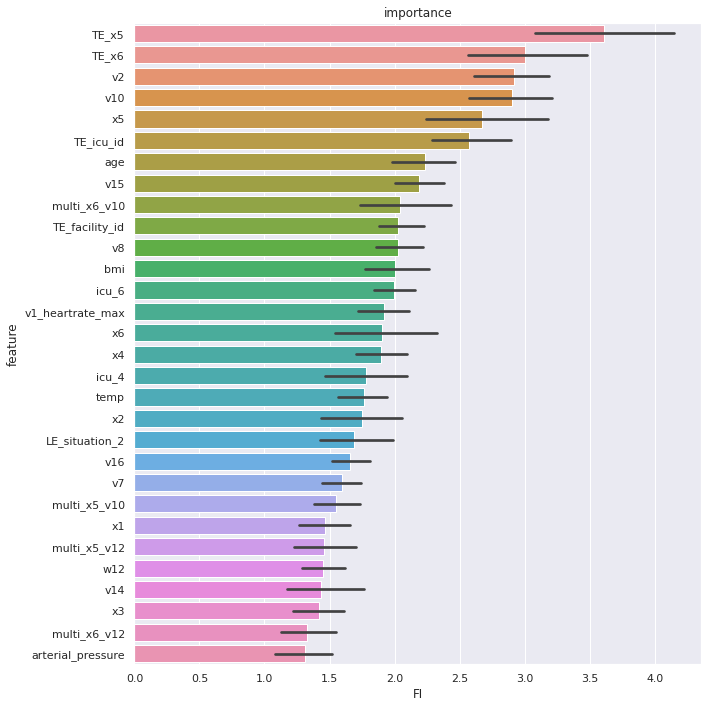

In [85]:
# feature_importances_ 上位20個の図示
TOP = 30

order = fi_df.groupby('feature')['FI'].mean().sort_values(ascending=False)[:TOP].index
# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x="FI",y="feature",data=fi_df,order=order)
plt.title('importance')
plt.tight_layout()
plt.show()

##displot

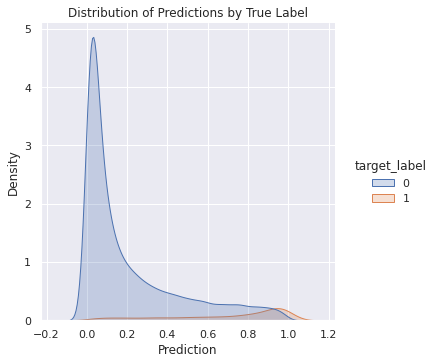

In [86]:
oof_df = pd.DataFrame({
    'oof': oof,
    'target_label':train['target_label']
})

# 'target_label'ごとの予測値の分布を可視化する
sns.displot(oof_df, x="oof", hue="target_label", kind="kde", fill=True)

# グラフのタイトルと軸ラベルを設定する
plt.title('Distribution of Predictions by True Label')
plt.xlabel('Prediction')
plt.ylabel('Density')

# グラフを表示する
plt.show()

In [90]:
submission['target_label'] = preds
submission.to_csv(paths.SUB_OUT+'submission.csv', index=False)